# Analyse des traces électromagnétiques
Nous allons analyser les traces collectées sur l'appareil à attaquer. En émettant des hypothèses de clés et en les testant sur les traces, nous allons pouvoir déterminer la clé utilisée pour chiffrer les données.

L'algorithme visée est l'AES-128. Il est basé sur 10 tours de chiffrement des données. Chaque tour réalise 3 opérations : 
- une substitution de bits (S-Box)
- un décalage de bits (ShiftRows)
- une multiplication de bits (MixColumns)

In [1]:
directory = 'TRACES_DATA_CONVERTED';
load('TRACES_DATA_CONVERTED\keys.mat')
load('TRACES_DATA_CONVERTED\pti.mat')
load('TRACES_DATA_CONVERTED\cto.mat')
load('TRACES_DATA_CONVERTED\traces.mat')

disp('Tailles des matrices :')
disp(['keys : ' num2str(size(keys))])
disp(['pti : ' num2str(size(pti))])
disp(['cto : ' num2str(size(cto))])
disp(['traces : ' num2str(size(traces))])

Tailles des matrices :
keys : 20000     16
pti : 20000     16
cto : 20000     16
traces : 20000   4000



# Affichage de la moyenne des traces
On trace la moyenne des traces sur un graphique. On voit que l'on obtient 12 pics. Or, on sait que l'AES-128 est sur 10 tours. 
Cette différence vient d'une mauvaise implémentation matérielle. C'est notamment pour cela que l'on attaque par le bas de l'algorithme.
=> On attaque sur le 10e round.

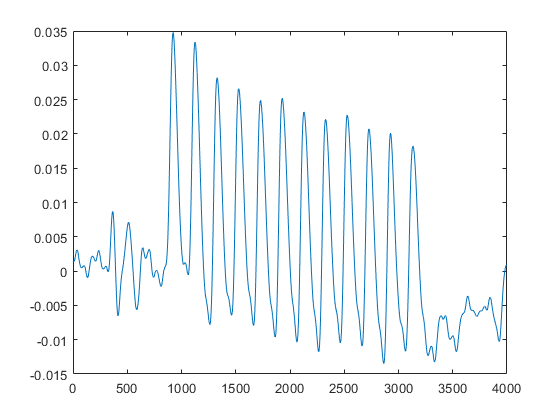

In [2]:
traces_mean = mean(traces);
figure
plot(traces_mean)


# Objectif
On cherche à inverser les fonctions de chiffrement. 
Notamment, on cherche à inverser la S_Box.

Etape 1 : on cherche les hypothèses sur les clés => $w_{10}$ \
Etape 2 : on crée toutes les hypothèses pour les sous-clés => $Z$ de dimension $[N_t \times 256]$ \
Etape 3 : on remonte les boîtes de l'algo (ShiftRow et SBox) \
Etape 4 : on fait une corrélation entre les traces et les hypothèses

In [2]:
keys4x4 = reshape(keys(1, :), [4 4])
all_w = keysched2(uint32(keys4x4));

all_w
w10 = all_w(:, :, 11) % point d'arrivée. Objectif de l'algorithme



keys4x4 =

    76   181   144   132
   140   201    87    25
   223     6   236    58
    35   247   113   103


  4x4x11 uint32 array

all_w(:,:,1) =

    76   181   144   132
   140   201    87    25
   223     6   236    58
    35   247   113   103


all_w(:,:,2) =

   153    44   188    56
    12   197   146   139
    90    92   176   138
   124   139   250   157


all_w(:,:,3) =

   166   138    54    14
   114   183    37   174
     4    88   232    98
   123   240    10   151


all_w(:,:,4) =

    70   204   250   244
   216   111    74   228
   140   212    60    94
   208    32    42   189


all_w(:,:,5) =

    39   235    17   229
   128   239   165    65
   246    34    30    64
   111    79   101   216


all_w(:,:,6) =

   180    95    78   171
   137   102   195   130
   151   181   171   235
   182   249   156    68


all_w(:,:,7) =

   135   216   150    61
    96     6   197    71
   140    57   146   121
   212    45   177   245


all_w(:,:,8) =

   103   191    41   

In [3]:
shiftrow = [1, 6, 11, 16, 5, 10, 15, 4, 9, 14, 3, 8, 13, 2, 7, 12];
shiftrow = reshape(shiftrow, [4 4]);

SBox = [99, 124, 119, 123, 242, 107, 111, 197, 48, 1, 103, 43, 254, 215, 171, 118, 202, 130, 201, 125, 250, 89, 71, 240, 173, 212, 162, 175, 156, 164, 114, 192, 183, 253, 147, 38, 54, 63, 247, 204, 52, 165, 229, 241, 113, 216, 49, 21, 4, 199, 35, 195, 24, 150, 5, 154, 7, 18, 128, 226, 235, 39, 178, 117, 9, 131, 44, 26, 27, 110, 90, 160, 82, 59, 214, 179, 41, 227, 47, 132, 83, 209, 0, 237, 32, 252, 177, 91, 106, 203, 190, 57, 74, 76, 88, 207, 208, 239, 170, 251, 67, 77, 51, 133, 69, 249, 2, 127, 80, 60, 159, 168, 81, 163, 64, 143, 146, 157, 56, 245, 188, 182, 218, 33, 16, 255, 243, 210, 205, 12, 19, 236, 95, 151, 68, 23, 196, 167, 126, 61, 100, 93, 25, 115, 96, 129, 79, 220, 34, 42, 144, 136, 70, 238, 184, 20, 222, 94, 11, 219, 224, 50, 58, 10, 73, 6, 36, 92, 194, 211, 172, 98, 145, 149, 228, 121, 231, 200, 55, 109, 141, 213, 78, 169, 108, 86, 244, 234, 101, 122, 174, 8, 186, 120, 37, 46, 28, 166, 180, 198, 232, 221, 116, 31, 75, 189, 139, 138, 112, 62, 181, 102, 72, 3, 246, 14, 97, 53, 87, 185, 134, 193, 29, 158, 225, 248, 152, 17, 105, 217, 142, 148, 155, 30, 135, 233, 206, 85, 40, 223, 140, 161, 137, 13, 191, 230, 66, 104, 65, 153, 45, 15, 176, 84, 187, 22];

invSBox(SBox(1:256) + 1) = 0:255;
size(SBox)
size(invSBox)

Weight_Hamming_vect = [0 1 1 2 1 2 2 3 1 2 2 3 2 3 3 4 1 2 2 3 2 3 3 4 2 3 3 4 3 4 4 5 1 2 2 3 2 3 3 4 2 3 3 4 3 4 4 5 2 3 3 4 3 4 4 5 3 4 4 5 4 5 5 6 1 2 2 3 2 3 3 4 2 3 3 4 3 4 4 5 2 3 3 4 3 4 4 5 3 4 4 5 4 5 5 6 2 3 3 4 3 4 4 5 3 4 4 5 4 5 5 6 3 4 4 5 4 5 5 6 4 5 5 6 5 6 6 7 1 2 2 3 2 3 3 4 2 3 3 4 3 4 4 5 2 3 3 4 3 4 4 5 3 4 4 5 4 5 5 6 2 3 3 4 3 4 4 5 3 4 4 5 4 5 5 6 3 4 4 5 4 5 5 6 4 5 5 6 5 6 6 7 2 3 3 4 3 4 4 5 3 4 4 5 4 5 5 6 3 4 4 5 4 5 5 6 4 5 5 6 5 6 6 7 3 4 4 5 4 5 5 6 4 5 5 6 5 6 6 7 4 5 5 6 5 6 6 7 5 6 6 7 6 7 7 8];



ans =

     1   256


ans =

     1   256




# A faire
- Inversion du shiftrow (faire des tests ou à la main)
- Calcul des Zi (Z3 notamment)
- Comparaison de la corrélation entre les traces et les hypothèses (Zi) => on cherche à trouver le max de corrélation


Poids Hamming déjà fourni => table de correspondance entre vals et poids hamming
SBox-1 déjà fourni aussi => table de correspondance entre vals et vals inversées

In [5]:
shiftrow = [1, 6, 11, 16, 5, 10, 15, 4, 9, 14, 3, 8, 13, 2, 7, 12];
shiftrow = reshape(shiftrow, [4 4]);
% size(shiftrow)
shiftrow
keys4x4_shifted = keys4x4(shiftrow);
keys4x4_shifted

for i = 1:4

    for j = 1:4
        inv_shiftrow(i, j) = mod(shiftrow(i, j) + 8 * mod(i - 1, 2), 16);

        if inv_shiftrow(i, j) == 0
            inv_shiftrow(i, j) = 16;
        end

    end

end

inv_shiftrow
keys4x4_shifted(inv_shiftrow)
% keys4x4_shifted
keys4x4
% size(inv(shiftrow))
% size(SBox)
% size(invSBox)



shiftrow =

     1     5     9    13
     6    10    14     2
    11    15     3     7
    16     4     8    12


keys4x4_shifted =

    76   181   144   132
   201    87    25   140
   236    58   223     6
   103    35   247   113


inv_shiftrow =

     1     5     9    13
    14     2     6    10
    11    15     3     7
     8    12    16     4


ans =

    76   181   144   132
   140   201    87    25
   223     6   236    58
    35   247   113   103


keys4x4 =

    76   181   144   132
   140   201    87    25
   223     6   236    58
    35   247   113   103




Penser à itérer les calculs que l'on fait sur 1 itérations pour les 16 valeurs que l'on a. (dans cto et pti)


In [9]:
hypothese = uint8(ones(size(cto, 1), 1) * (0:255));
size(hypothese)
cto_extended = uint8(single(cto(:, 1)) * ones(1, 256));
size(cto_extended)

Z1 = bitxor(cto_extended, hypothese);
Z1(1:10, 1:10)
size(Z1)

% On inverse le vecteur shiftrow
% Z2 = Z1(inv_shiftrow)
% Z2(1:10, 1:10)
% size(Z2)
% Z2 = shiftrow(Z1);


ans =

       20000         256


ans =

       20000         256


ans =

  10x10 uint8 matrix

    85    84    87    86    81    80    83    82    93    92
   110   111   108   109   106   107   104   105   102   103
    30    31    28    29    26    27    24    25    22    23
   137   136   139   138   141   140   143   142   129   128
   239   238   237   236   235   234   233   232   231   230
   121   120   123   122   125   124   127   126   113   112
   155   154   153   152   159   158   157   156   147   146
   208   209   210   211   212   213   214   215   216   217
    15    14    13    12    11    10     9     8     7     6
   244   245   246   247   240   241   242   243   252   253


ans =

       20000         256




In [5]:
size(Z1)
size(Weight_Hamming_vect)
pt_attack1=Z1(Weight_Hamming_vect+1);
pt2=Weight_Hamming_vect(Z1+1);
% size(pt_attack1)
sum(pt_attack1);
% pt2=sum(pt2);


ans =

       20000         256


ans =

     1   256




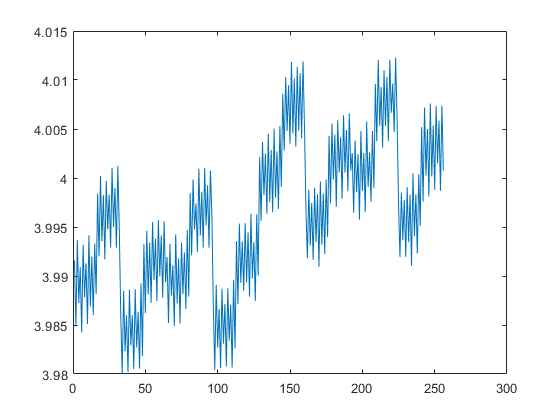

In [21]:
pt2_mean = mean(pt2);
plot(pt2_mean)
% plot(pt2)

In [7]:
Z3=invSBox(Z1+1);
size(Z3)
pt3=Weight_Hamming_vect(Z3+1);
size(pt3)


ans =

       20000         256


ans =

       20000         256





ans =

       20000         256




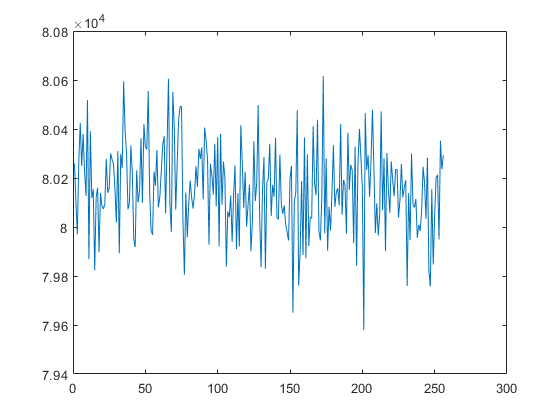

In [11]:
distance_hamming = Weight_Hamming_vect(bitxor(uint8(Z3), uint8(Z1))+1);
size(distance_hamming)
plot(sum(distance_hamming))


ans =

     1   256




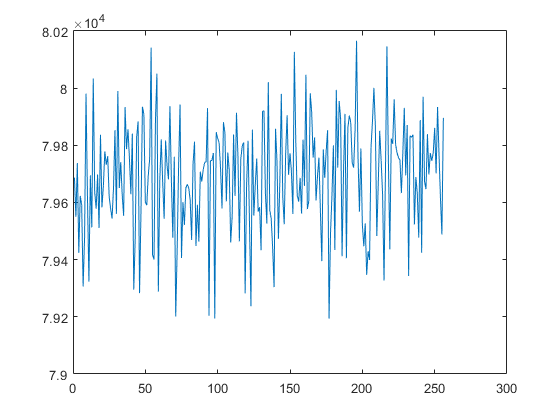

In [10]:
pt3_affichage = sum(pt3);
size(pt3_affichage)
plot(pt3_affichage)
% plot(pt3)

In [12]:
correlation = corr(single(distance_hamming), traces);
% corr(single(pt3), traces);
size(correlation)
% plot(0:size(correlation, 2) - 1, correlation(1:256, :));


ans =

         256        4000




In [19]:
[RK,IK] = sort(max(abs(correlation),[],2),'descend');
sprintf('meilleur candidat : k = %d RK = %d size IK = %d',IK(1), RK(1), size(IK))
best_candidate=IK(1);


ans =

    'meilleur candidat : k = 68 RK = 3.662976e-02 size IK = 256meilleur candidat : k = 1 RK = '




In [13]:

size(pti)
size(cto)
pti(1, :)

cto(1, :)


ans =

       20000          16


ans =

       20000          16


ans =

   139    80    97   202   214   174   106   164    54   158   172   153    88    93    43   203


ans =

    85    75    64   125    54    52    21   108     8    26   190    49   117    46   189     2




In [14]:
matrix = ones(size(cto,1),1) * (0:255);
size(matrix)

% matrix2= single(cto) * ones(1, 16);
% size(matrix2)


ans =

       20000         256




# Programme complet - attaque par analyse EMA
Ci-dessous se trouve le programme complet qui est un assemblage de tous les éléments ci-dessus. Il permet de réaliser l'attaque par analyse EMA.
Le programme renvoie la clé trouvée lors de l'attaque.

# Note sur la distance de Hamming
Pour faire le bon calcul de distance de hamming, il faut comparer les bonnes valeurs entre elles. Ainsi, quand on commence avec la valeur $cto_{1,1}$, on doit la comparer avec la valeur $cto_{1,1}$ après passage dans l'algo. Ensuite, la valeur $cto_{2,1}$ sera comparée avec la valeur $cto_{2,4}$ après passage dans l'algo car on doit faire la comparaison des mêmes valeurs. (Fonctionnement du `shiftrow`)


<!-- Matrices de cto -->
Matrice de cto avant passage dans l'algo : 
$\begin{pmatrix}
\text{cto}_{1,1} & \text{cto}_{1,2} & \text{cto}_{1,3} & \text{cto}_{1,4} \\
\text{cto}_{2,1} & \text{cto}_{2,2} & \text{cto}_{2,3} & \text{cto}_{2,4} \\
\text{cto}_{3,1} & \text{cto}_{3,2} & \text{cto}_{3,3} & \text{cto}_{3,4} \\
\text{cto}_{4,1} & \text{cto}_{4,2} & \text{cto}_{4,3} & \text{cto}_{4,4} \\
\end{pmatrix}$

Matrice de cto après passage dans l'algo :
$\begin{pmatrix}
\text{cto}_{1,1} & \text{cto}_{1,2} & \text{cto}_{1,3} & \text{cto}_{1,4} \\
\text{cto}_{2,4} & \text{cto}_{2,1} & \text{cto}_{2,2} & \text{cto}_{2,3} \\
\text{cto}_{3,3} & \text{cto}_{3,4} & \text{cto}_{3,1} & \text{cto}_{3,2} \\
\text{cto}_{4,2} & \text{cto}_{4,3} & \text{cto}_{4,4} & \text{cto}_{4,1} \\
\end{pmatrix}$

In [4]:
line = 1:16;
line = reshape(line, [4 4]);
line
for i = 1:4
    line(i, :) = circshift(line(i, :), i - 1);    
end
line


line =

     1     5     9    13
     2     6    10    14
     3     7    11    15
     4     8    12    16


line =

     1     5     9    13
    14     2     6    10
    11    15     3     7
     8    12    16     4




In [17]:
cto4x4=reshape(cto, [4 4 size(cto, 1)]);
size(cto4x4);
for i = 1:size(cto, 1)
    cto4x4(:,:,i) = reshape(cto(i, :), [4 4]);
end
reshape(cto(1, :), [4 4]);
cto4x4(:,:,100);
size(cto4x4(1,:,:))
cto4x4(1,:,1:3)
circshift(cto4x4(1,:,1:3), 1)


ans =

           1           4       20000


ans(:,:,1) =

    85    54     8   117


ans(:,:,2) =

   110   229   213   178


ans(:,:,3) =

    30   130   250    63


ans(:,:,1) =

   117    85    54     8


ans(:,:,2) =

   178   110   229   213


ans(:,:,3) =

    63    30   130   250




In [18]:
keys4x4 = reshape(keys(1, :), [4 4]);
all_w = keysched2(uint32(keys4x4));
w10 = all_w(:, :, 11) % point d'arrivée. Objectif de l'algorithme. (w10)

% reshape de cto en 4x4xsize(cto, 1) => 4x4x20000 ici.
for i = 1:size(cto, 1)
    cto4x4(:,:,i) = reshape(cto(i, :), [4 4]);
end
% Hypothèse linéaire de sous-clés (256 possibilités)
hypothese = uint32(ones(size(cto, 1), 1) * (0:255));

for i = 1:4
    cto_line = cto4x4(i, :, :); % 1x4x20000
    cto_line_shifted = circshift(cto_line, i-1);
    for j = 1:4
        % Hypothese
        cto_extended = uint32(single(cto_line(i,j,:)) * ones(1, 256));
        cto_extended_shifted = uint32(single(cto_line_shifted(i,j,:)) * ones(1, 256));
        % Points d'attaque
        Z1(:,:,j) = bitxor(cto_extended, hypothese);
        Z1_shifted(:,:,j) = bitxor(cto_extended_shifted, hypothese);
        Z3(:,:,j) = invSBox(Z1_shifted(:,:,j) + 1);
    end
    distance_hamming = Weight_Hamming_vect(bitxor(uint32(Z3), uint32(Z1)) + 1);
    % Correlation
    correlation = corr(single(distance_hamming), traces);
    [RK, IK] = sort(max(abs(correlation), [], 2), 'descend');
    % sprintf('meilleur candidat : k = %d RK = %d size IK = (%d,%d)', IK(1), RK(1), size(IK))
    best_candidate(i) = IK(1);
end
best_candidate = reshape(best_candidate, [4 4])


Arguments must be 2-D, or at least one argument must be scalar. Use TIMES (.*) for elementwise multiplication, use PAGEMTIMES to apply matrix multiplication to the pages of N-D arrays, or use TENSORPROD to find a product between two N-D arrays.

